In [2]:
# Add parent directory to PYTHONPATH of the notebook
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f"Adding parent directory to sys.path: {parent_dir}")
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Path to data files
data_path = '../data/'


%load_ext autoreload
%autoreload 2

Adding parent directory to sys.path: c:\Users\Łukasz\OneDrive - Politechnika Warszawska\MINI_1D\Semestr 8\Advanced ML\Project_2\AML_Feature_Selection


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

def remove_correlated_features(X, threshold=0.8):
    """
    Remove features with correlation coefficient higher than the threshold.
    Returns the dataframe with correlated features removed.
    """
    # Calculate the correlation matrix
    corr_matrix = X.corr().abs()
    
    # Create a mask for the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Number of features to drop based on correlation threshold {threshold}: {len(to_drop)}")
    
    if len(to_drop) > 0:
        print("Features being dropped due to high correlation:")
        for col in to_drop:
            # Find which features this column is correlated with
            correlated_with = upper[col][upper[col] > threshold].index.tolist()
            print(f"- {col} correlated with: {', '.join(correlated_with)}")
    
    # Create a new dataframe without the correlated features
    X_reduced = X.drop(columns=to_drop)
    return X_reduced

In [4]:
# Load the data
X_train = pd.read_csv(data_path + 'x_train.txt', delimiter=' ', header=None)
y_train = pd.read_csv(data_path + 'y_train.txt', delimiter=' ', header=None).squeeze()
X_test = pd.read_csv(data_path + 'x_test.txt', delimiter=' ', header=None)

# Rename columns for better readability
X_train.columns = [f'feature_{i}' for i in range(X_train.shape[1])]
X_test.columns = [f'feature_{i}' for i in range(X_test.shape[1])]

# Display basic information about the data
print("Training data shape:", X_train.shape)
print("Target variable shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("\nClass distribution in training data:")
print(y_train.value_counts(normalize=True) * 100)

# Split the training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print("\nAfter splitting:")
print("Train set shape:", X_train_split.shape)
print("Validation set shape:", X_val.shape)

display(X_train_split.head())
display(y_train_split)

Training data shape: (5000, 500)
Target variable shape: (5000,)
Test data shape: (5000, 500)

Class distribution in training data:
0
0    51.14
1    48.86
Name: proportion, dtype: float64

After splitting:
Train set shape: (4000, 500)
Validation set shape: (1000, 500)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_490,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499
1796,10.994454,7.223997,18.905844,15.302758,11.335159,11.268610,16.742562,11.595944,11.898338,11.381933,...,8.083485,9.417854,18.105234,2.648145,6.880692,4.950240,11.992575,8.532587,14.966706,21.897683
3243,18.329623,13.311553,24.541799,16.356399,20.784595,11.251973,15.867162,17.039225,10.326017,16.232807,...,13.244366,8.005045,4.562646,5.814640,11.137799,19.105339,4.509459,10.775882,3.348956,7.777499
2491,8.856867,8.177936,16.285177,9.685481,11.551787,4.839914,10.932191,7.374404,8.853780,10.378997,...,9.533385,12.313883,3.841512,6.604631,7.065970,7.968559,13.224610,9.949868,2.687109,11.251411
2106,23.597065,22.040934,43.749375,30.131020,30.131190,16.708132,29.810484,25.257863,24.452841,27.266843,...,8.631784,7.659637,12.655417,5.507021,12.309867,2.966007,4.071214,17.345237,6.848255,11.848773
1644,20.971488,18.626463,33.579955,19.998639,26.105883,9.787864,20.467935,18.329333,14.347480,23.615695,...,12.014632,16.713876,6.763858,13.764160,6.576413,21.474574,6.643161,11.400546,11.648409,12.634681


1796    0
3243    0
2491    0
2106    1
1644    1
       ..
4365    0
611     0
1003    0
3743    0
818     1
Name: 0, Length: 4000, dtype: int64

In [5]:
# Standard scaling (mean=0, std=1)
scaler = StandardScaler()
X_train_split_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create DataFrames from the scaled arrays and index from original data
X_train_split_scaled_df = pd.DataFrame(X_train_split_scaled, columns=X_train_split.columns, index=X_train_split.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Save the new data
save_path = '../data/scaled/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Ensure the data is consistent with the original data
# Before
display(X_train_split.head(3))
# After
display(X_train_split_scaled_df.head(3))
# y_train_split
display(y_train_split.head(3))

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_490,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499
1796,10.994454,7.223997,18.905844,15.302758,11.335159,11.268610,16.742562,11.595944,11.898338,11.381933,...,8.083485,9.417854,18.105234,2.648145,6.880692,4.950240,11.992575,8.532587,14.966706,21.897683
3243,18.329623,13.311553,24.541799,16.356399,20.784595,11.251973,15.867162,17.039225,10.326017,16.232807,...,13.244366,8.005045,4.562646,5.814640,11.137799,19.105339,4.509459,10.775882,3.348956,7.777499
2491,8.856867,8.177936,16.285177,9.685481,11.551787,4.839914,10.932191,7.374404,8.853780,10.378997,...,9.533385,12.313883,3.841512,6.604631,7.065970,7.968559,13.224610,9.949868,2.687109,11.251411


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_490,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499
1796,-1.061760,-1.430582,-1.269855,-0.705374,-1.475228,-0.150262,-0.492853,-0.898017,-0.509204,-0.961760,...,-0.428594,-0.129728,1.770227,-1.641438,-0.694539,-1.101744,0.420421,-0.327320,1.109481,2.629266
3243,0.635321,0.173405,-0.459863,-0.492530,0.326602,-0.154819,-0.657300,0.327381,-0.862406,0.047546,...,0.720985,-0.447933,-1.201419,-0.931852,0.249667,2.052077,-1.233392,0.176505,-1.495024,-0.502881
2491,-1.556317,-1.179233,-1.646494,-1.840114,-1.433921,-1.911075,-1.584349,-1.848375,-1.193125,-1.170438,...,-0.105631,0.522542,-1.359657,-0.754821,-0.653445,-0.429249,0.692709,-0.009011,-1.643400,0.267704


1796    0
3243    0
2491    0
Name: 0, dtype: int64

In [6]:
X_train_split_scaled_df.to_csv(save_path + 'x_train_scaled.txt', index=True, header=True, sep=' ')
X_val_scaled_df.to_csv(save_path + 'x_val_scaled.txt', index=True, header=True, sep=' ')
X_test_scaled_df.to_csv(save_path + 'x_test_scaled.txt', index=True, header=True, sep=' ')
y_train_split.to_csv(save_path + 'y_train.txt', index=True, header=False, sep=' ')
y_val.to_csv(save_path + 'y_val.txt', index=True, header=False, sep=' ')

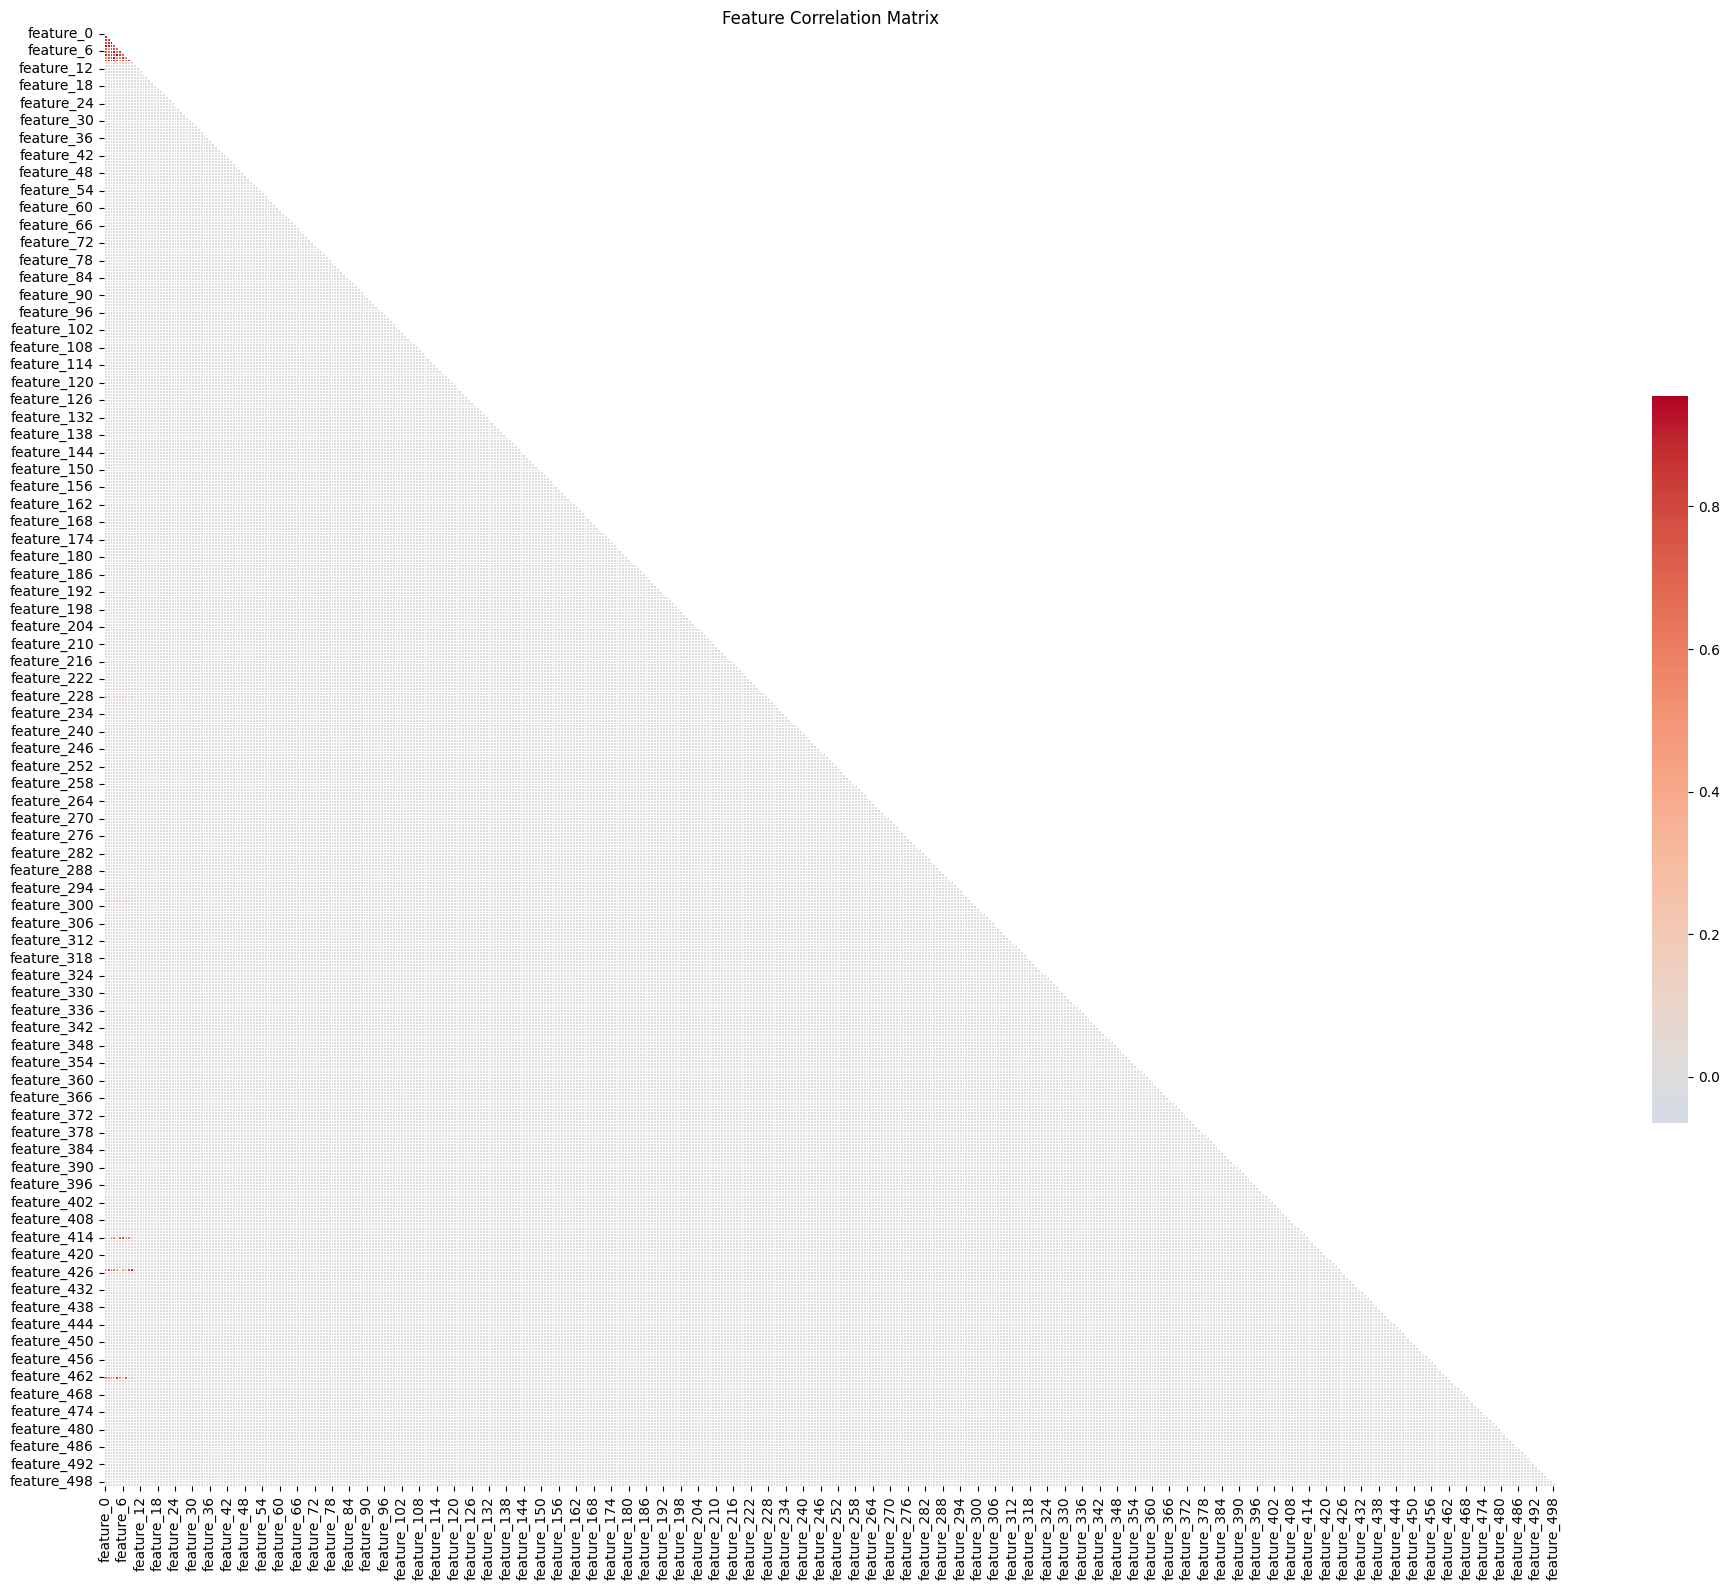

Found 60 feature pairs with correlation > 0.5

--- Top 10 highest correlations ---
feature_4 — feature_7: 0.955
feature_0 — feature_4: 0.944
feature_3 — feature_8: 0.929
feature_2 — feature_3: 0.928
feature_1 — feature_4: 0.906
feature_0 — feature_7: 0.903
feature_3 — feature_6: 0.903
feature_2 — feature_4: 0.889
feature_1 — feature_9: 0.889
feature_2 — feature_7: 0.879

--- 5 lowest correlations among features above threshold ---
feature_7 — feature_8: 0.572
feature_2 — feature_414: 0.544
feature_1 — feature_462: 0.533
feature_5 — feature_462: 0.518
feature_6 — feature_425: 0.502


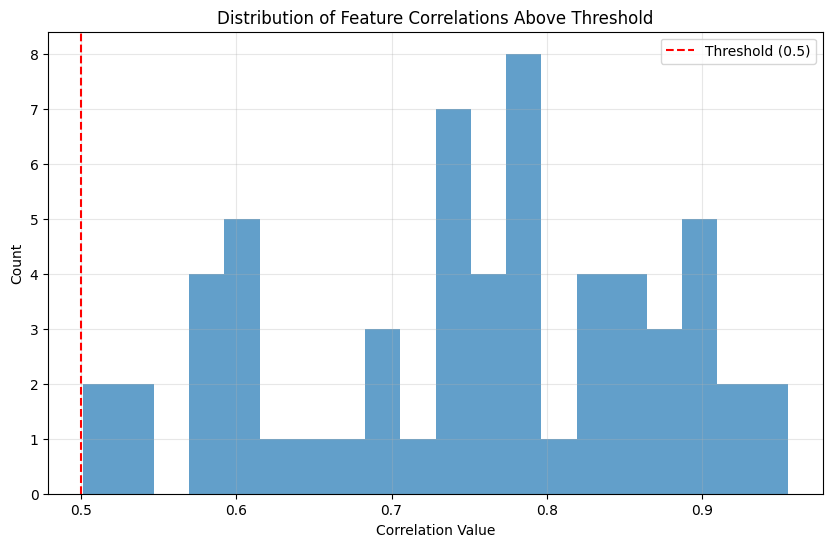

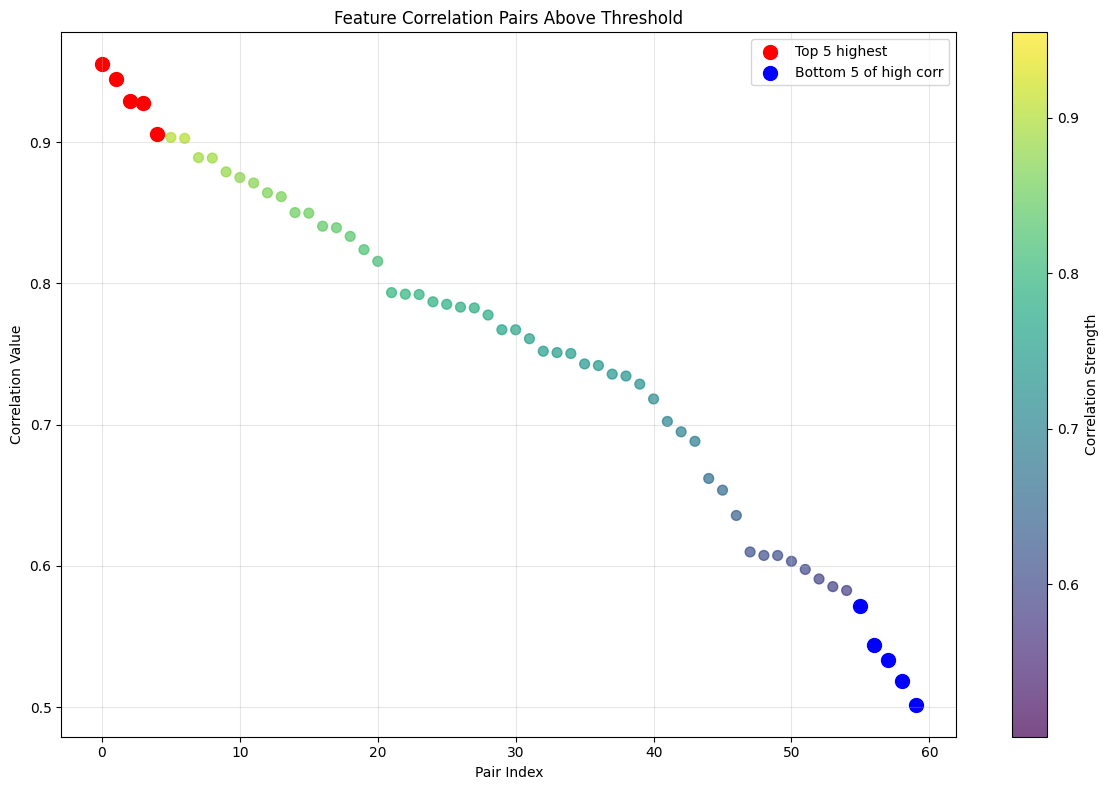


--- Visualizing top correlations ---

--- Visualizing lowest correlations above threshold ---


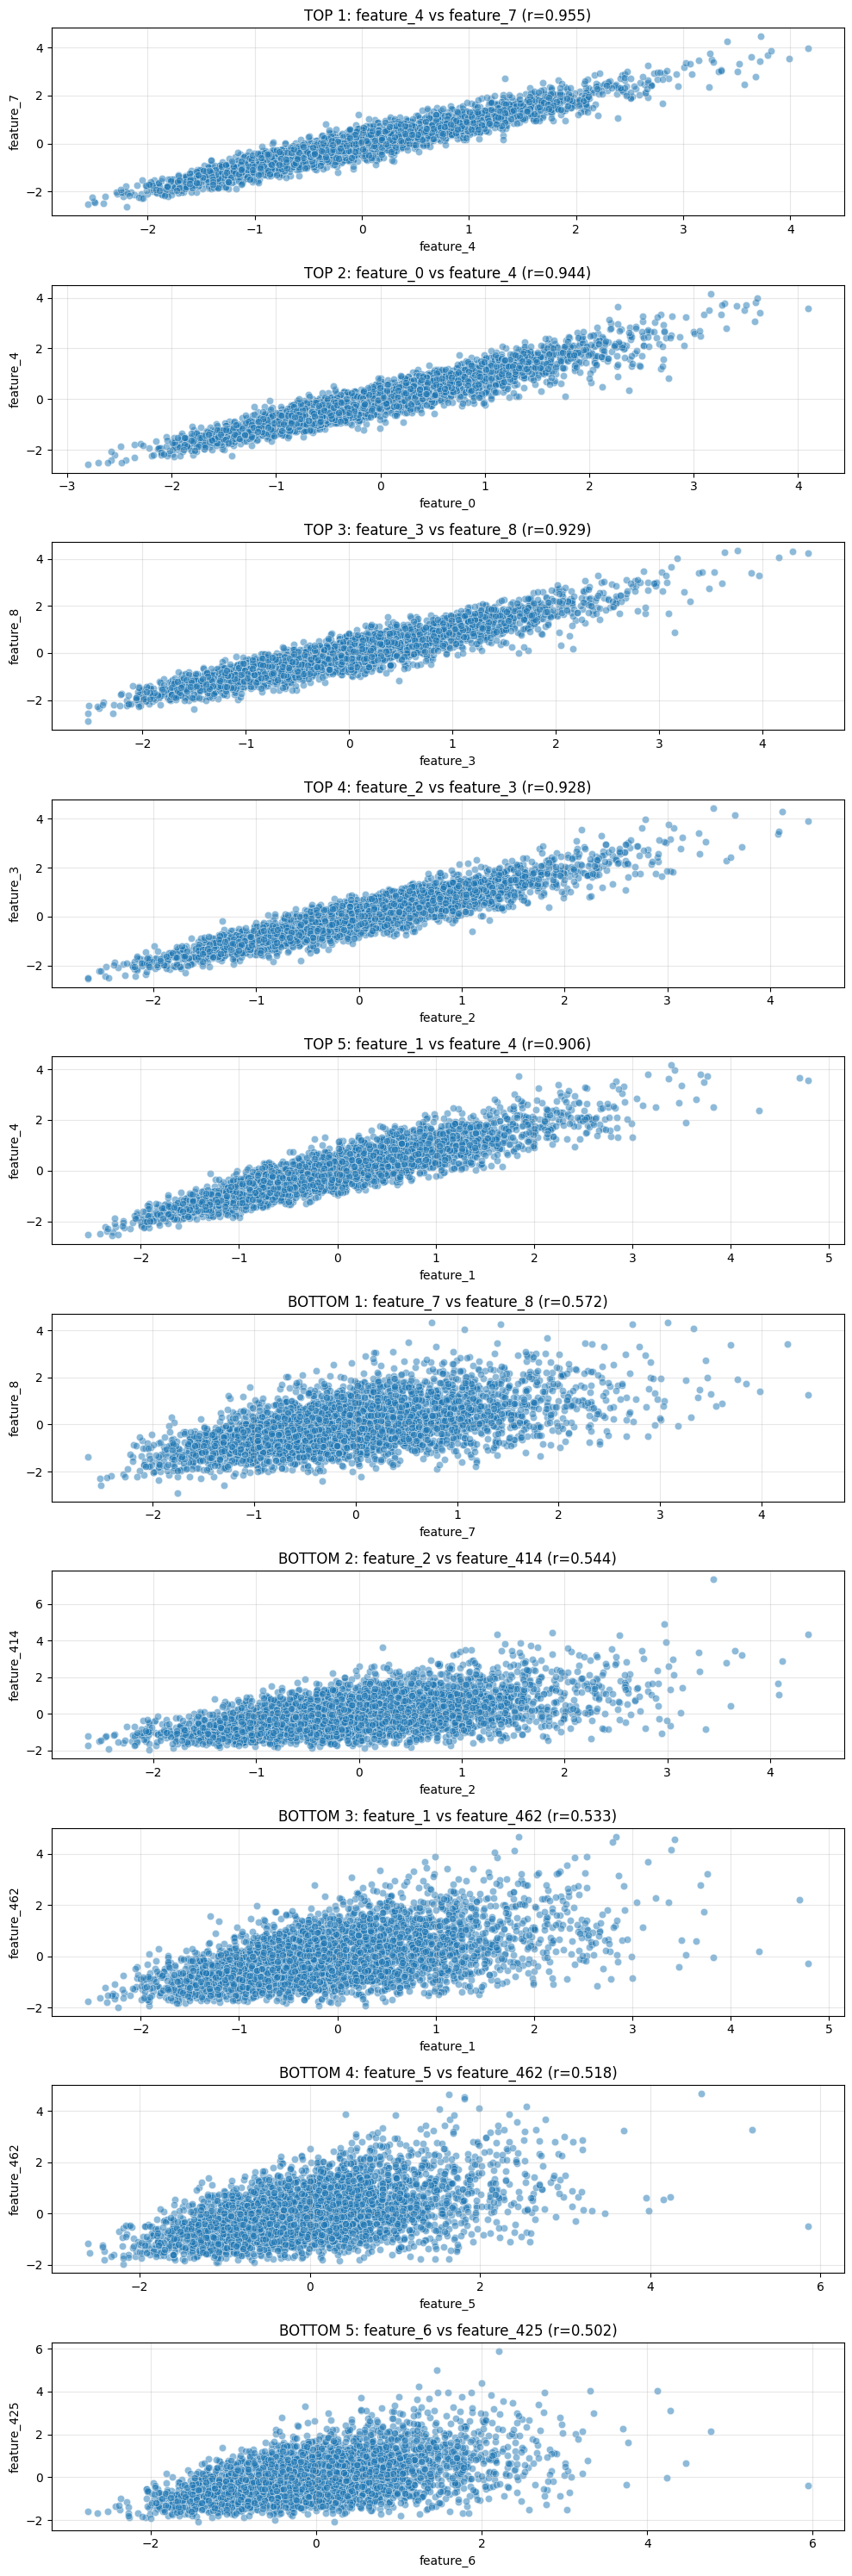

In [7]:
# Set the correlation threshold
correlation_threshold = 0.5

# Visualize the correlation matrix before removing features
plt.figure(figsize=(20, 16))
corr_matrix = X_train_split_scaled_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, center=0, cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify pairs of features with correlation above the threshold
corr_matrix = X_train_split_scaled_df.corr().abs()
# Get the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# Find feature pairs with correlation above threshold
high_corr_pairs = []

for i in range(len(upper.columns)):
    for j in range(i+1, len(upper.columns)):
        if upper.iloc[i, j] > correlation_threshold:
            high_corr_pairs.append((upper.columns[i], upper.columns[j], upper.iloc[i, j]))

# Sort by correlation value (descending)
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)

# Print the highest correlated feature pairs
print(f"Found {len(high_corr_pairs)} feature pairs with correlation > {correlation_threshold}")

print("\n--- Top 10 highest correlations ---")
for feat1, feat2, corr in high_corr_pairs[:10]:  # Show top 10
    print(f"{feat1} — {feat2}: {corr:.3f}")
    
if len(high_corr_pairs) >= 5:
    print("\n--- 5 lowest correlations among features above threshold ---")
    for feat1, feat2, corr in high_corr_pairs[-5:]:  # Show bottom 5 from high correlations
        print(f"{feat1} — {feat2}: {corr:.3f}")

# Also show the overall feature-to-feature correlation distribution
if len(high_corr_pairs) > 0:
    # Extract just the correlation values
    corr_values = [corr for _, _, corr in high_corr_pairs]
    
    # Plot histogram of correlation values
    plt.figure(figsize=(10, 6))
    plt.hist(corr_values, bins=20, alpha=0.7)
    plt.axvline(correlation_threshold, color='red', linestyle='--', 
                label=f'Threshold ({correlation_threshold})')
    plt.title('Distribution of Feature Correlations Above Threshold')
    plt.xlabel('Correlation Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Create scatter plot showing pairs with color based on correlation strength
    plt.figure(figsize=(12, 8))
    # Select a subset if there are too many points
    max_points = 200
    plot_pairs = high_corr_pairs[:max_points] if len(high_corr_pairs) > max_points else high_corr_pairs
    
    # Extract top pairs for scatter plot
    x_vals = np.arange(len(plot_pairs))
    y_vals = [corr for _, _, corr in plot_pairs]
    
    # Create scatter with color gradient
    scatter = plt.scatter(x_vals, y_vals, c=y_vals, cmap='viridis', 
                          alpha=0.7, s=50)
    plt.colorbar(scatter, label='Correlation Strength')
    
    # Highlight highest and lowest correlations
    plt.scatter(x_vals[:5], y_vals[:5], color='red', s=100, label='Top 5 highest')
    plt.scatter(x_vals[-5:], y_vals[-5:], color='blue', s=100, label='Bottom 5 of high corr')
    
    plt.title('Feature Correlation Pairs Above Threshold')
    plt.xlabel('Pair Index')
    plt.ylabel('Correlation Value')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

        # Calculate total number of plots (top 5 + bottom 5 if available)
    num_top = min(5, len(high_corr_pairs))
    num_bottom = min(5, len(high_corr_pairs))
    total_plots = num_top + num_bottom
    
    # Create subplots for top and bottom correlations
    fig, axes = plt.subplots(total_plots, 1, figsize=(10, 3*total_plots))
    
    if total_plots == 1:
        axes = [axes]  # Make axes iterable if only one plot
    
    # Plot top correlations
    print("\n--- Visualizing top correlations ---")
    for i, (feat1, feat2, corr) in enumerate(high_corr_pairs[:num_top]):
        sns.scatterplot(
            x=X_train_split_scaled_df[feat1],
            y=X_train_split_scaled_df[feat2],
            ax=axes[i],
            alpha=0.5
        )
        axes[i].set_title(f"TOP {i+1}: {feat1} vs {feat2} (r={corr:.3f})")
        axes[i].grid(alpha=0.3)
    
    # Plot bottom correlations (if we have enough pairs)
    if len(high_corr_pairs) > num_top:
        print("\n--- Visualizing lowest correlations above threshold ---")
        for i, (feat1, feat2, corr) in enumerate(high_corr_pairs[-num_bottom:]):
            sns.scatterplot(
                x=X_train_split_scaled_df[feat1],
                y=X_train_split_scaled_df[feat2],
                ax=axes[i+num_top],
                alpha=0.5
            )
            axes[i+num_top].set_title(f"BOTTOM {i+1}: {feat1} vs {feat2} (r={corr:.3f})")
            axes[i+num_top].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"No feature pairs found with correlation above {correlation_threshold}")

Found 60 feature pairs with correlation > 0.5
feature_4 — feature_7: 0.955
feature_0 — feature_4: 0.944
feature_3 — feature_8: 0.929
feature_2 — feature_3: 0.928
feature_1 — feature_4: 0.906
feature_0 — feature_7: 0.903
feature_3 — feature_6: 0.903
feature_2 — feature_4: 0.889
feature_1 — feature_9: 0.889
feature_2 — feature_7: 0.879


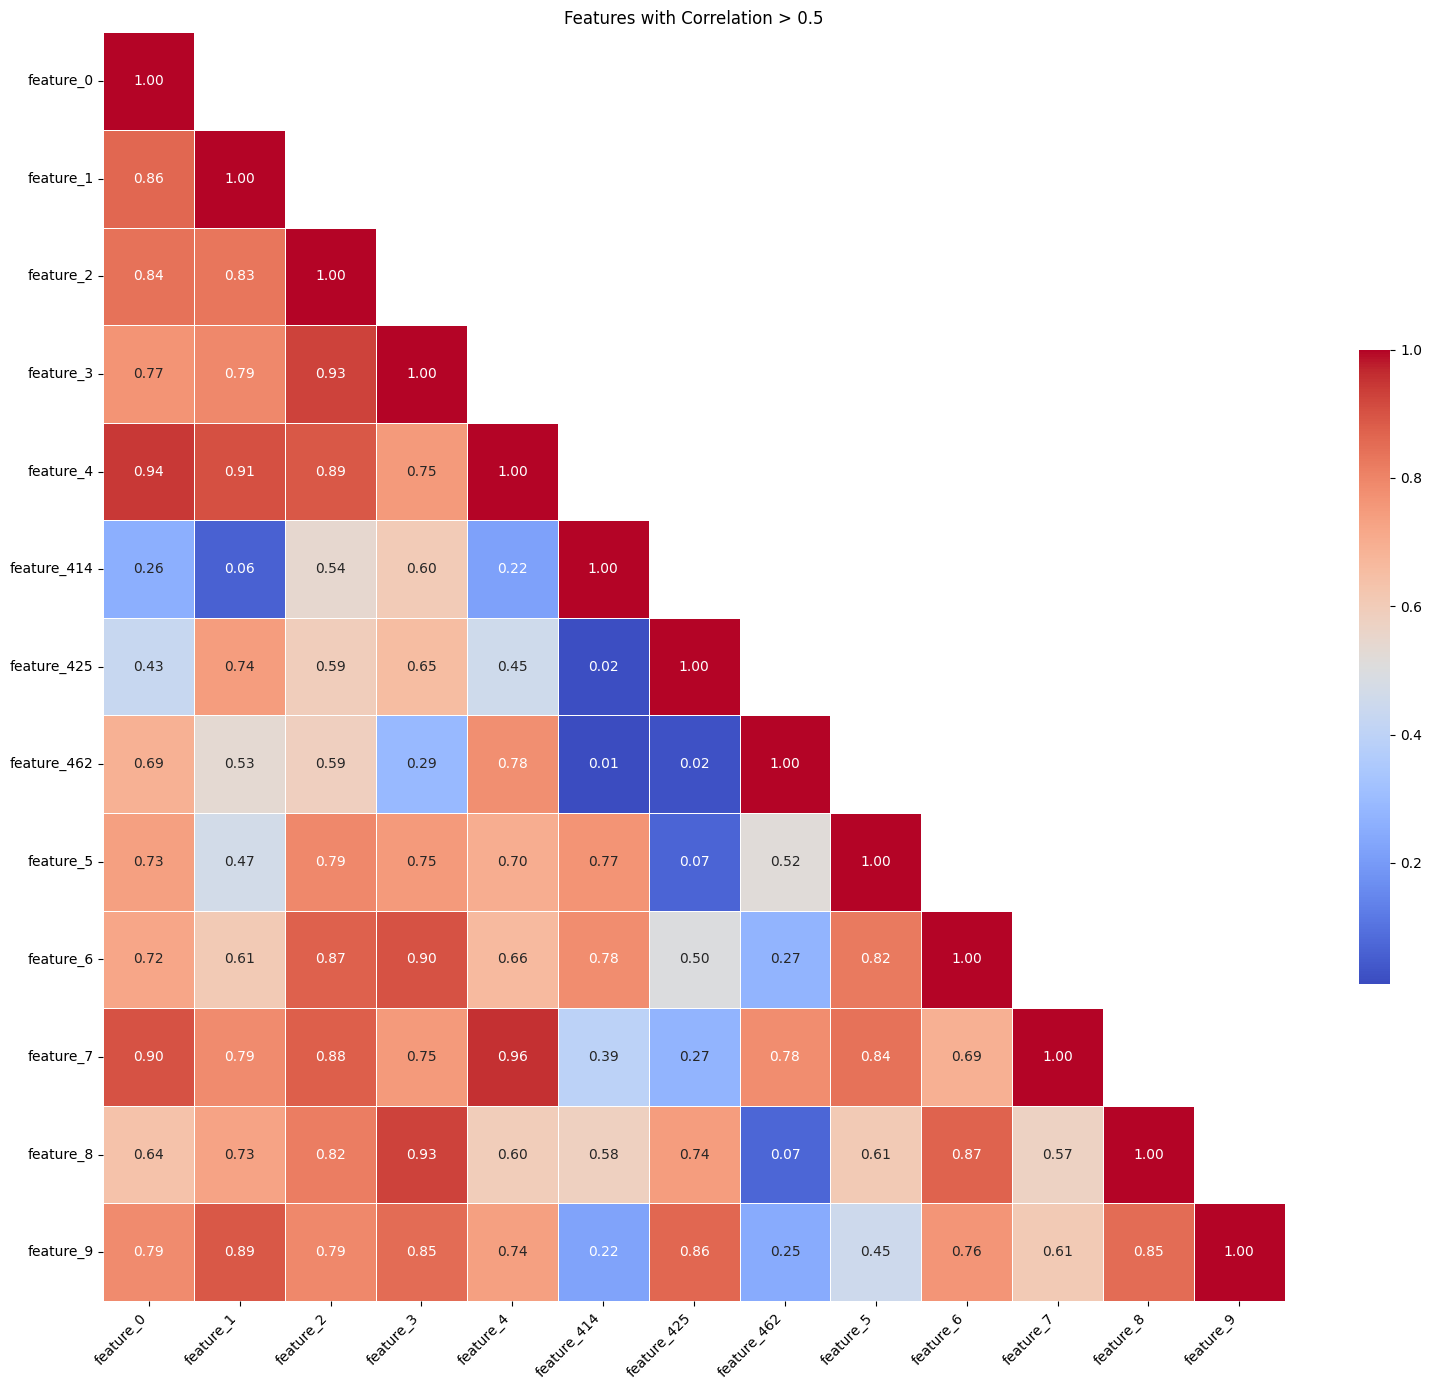

In [11]:
corr_matrix = X_train_split_scaled_df.corr().abs()
# Get the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# Find feature pairs with correlation above threshold
high_corr_pairs = []

for i in range(len(upper.columns)):
    for j in range(i+1, len(upper.columns)):
        if upper.iloc[i, j] > correlation_threshold:
            high_corr_pairs.append((upper.columns[i], upper.columns[j], upper.iloc[i, j]))

# Sort by correlation value (descending)
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)

# Print the highly correlated feature pairs
print(f"Found {len(high_corr_pairs)} feature pairs with correlation > {correlation_threshold}")
for feat1, feat2, corr in high_corr_pairs[:10]:  # Show top 10
    print(f"{feat1} — {feat2}: {corr:.3f}")

if len(high_corr_pairs) > 0:
    # Create a heatmap with only high correlation features
    # Get unique features from the high correlation pairs
    high_corr_features = set()
    for feat1, feat2, _ in high_corr_pairs:
        high_corr_features.add(feat1)
        high_corr_features.add(feat2)
    
    high_corr_features = sorted(list(high_corr_features))
    
    # Create a filtered correlation matrix
    high_corr_matrix = X_train_split_scaled_df[high_corr_features].corr()
    
    # Plot the heatmap with triangular mask
    plt.figure(figsize=(16, 14))

    # Create mask for the lower triangle
    mask = np.triu(np.ones_like(high_corr_matrix), k=1)  # k=0 includes diagonal, k=1 excludes diagonal

    # Apply mask to show only upper triangle (by masking lower triangle)
    sns.heatmap(high_corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f",
                linewidths=.5, cbar_kws={"shrink": .5})

    plt.title(f'Features with Correlation > {correlation_threshold}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
else:
    print(f"No feature pairs found with correlation above {correlation_threshold}")